In [0]:
%run "/Market Monitoring/eatools"

In [0]:
import fileinput
import matplotlib.pyplot as plt 
import matplotlib.ticker  
import matplotlib.dates
import matplotlib
import matplotlib.pyplot as plt
import pandas.io.sql
import datetime
import numpy as np
from pandas import *
import pandas as pd
import ossaudiodev
from datetime import date, datetime, time, timedelta
inputPath='/dbfs/mnt/mmdatastoresaprd/data/Roger/HSOTC/'

### Overview of data sources and calculation of carbon impact on SRMC

1. Historical carbon (NZU) price sourced from:
   - recent data from emsTradepoint
   - older data from 'NZ ETS' series at https://icapcarbonaction.com/en/ets-prices


2. Obtain parameters for different plants:
   -	heat rate (HR) (GJ/MWh) (source: Table 3-13 of https://www.mbie.govt.nz/assets/2020-thermal-generation-stack-update-report.pdf)
   
   -	emission factor (EF) (tonnes CO2 per TJ) (source: Tables A4.1 (gas = 'Weighted Average' and diesel = 'Diesel (10 parts (sulphur) per million)') and A4.2 (coal = latest value (2018)) of https://environment.govt.nz/assets/Publications/Files/new-zealands-greenhouse-gas-inventory-1990-2018-vol-2-annexes_July2020.pdf)
   
   
3.	For each thermal station calculate: carbonImpost(date) = HR\*(EF/1000\*carbonPrice(date))
where: 
   - carbonImpost(date) is a series in \$/MWh
   - carbonPrice(date) is the price series in \$/tonne of CO2 equivalent
   - HR, EF as above

### Import Carbon Price Series

In [0]:
carbonPriceDaily=pd.read_csv(inputPath+'carbonPriceDaily.csv',parse_dates=[0],index_col=[0])

In [0]:
carbonPriceDaily.tail()

carbon 
 
 
 date 
 
 
 
 
 
 2022-06-26 
 76.92 
 
 
 2022-06-27 
 76.92 
 
 
 2022-06-28 
 76.92 
 
 
 2022-06-29 
 76.47 
 
 
 2022-06-30 
 76.47

In [0]:
# Convert to monthly 
carbonPrice=carbonPriceDaily.resample('MS').mean()
carbonPrice.tail(12)

carbon 
 
 
 date 
 
 
 
 
 
 2022-01-01 
 69.468000 
 
 
 2022-02-01 
 78.681364 
 
 
 2022-03-01 
 74.450400 
 
 
 2022-04-01 
 75.555833 
 
 
 2022-05-01 
 76.198400 
 
 
 2022-06-01 
 76.172917 
 
 
 2022-07-01 
 74.390000 
 
 
 2022-08-01 
 74.615000 
 
 
 2022-09-01 
 74.448333 
 
 
 2022-10-01 
 74.696667 
 
 
 2022-11-01 
 74.363333 
 
 
 2022-12-01 
 74.403333

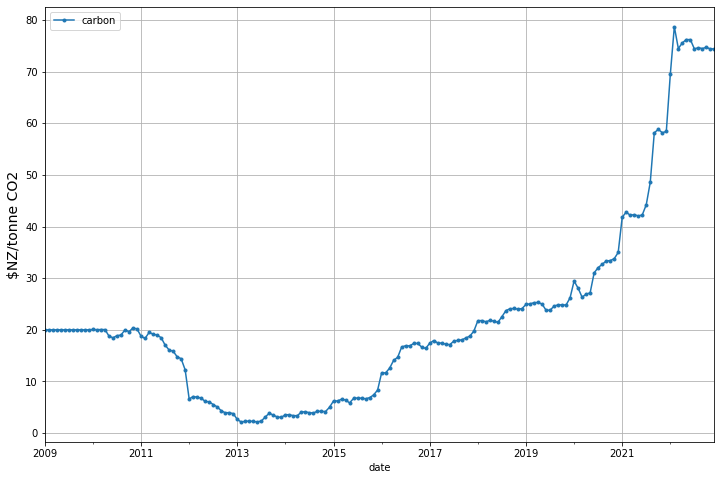

In [0]:
carbonPrice.plot(figsize=[12,8],marker='.')
plt.ylabel('$NZ/tonne CO2', fontsize=14)
plt.grid()

### Determine Carbon Price Impact on SRMC of each thermal plant

In [0]:
params=pd.read_csv(inputPath+'carbonFactors.csv',index_col=[0])
params

Heat Rate (GJ/MWh) 
 Emission Factor (t CO2/TJ) 
 
 
 GENERATOR 
 
 
 
 
 
 
 Huntly e3p U5 
 7.400 
 53.97 
 
 
 TCC CCGT 
 7.400 
 53.97 
 
 
 Huntly Rankine U1,2,4 coal 
 10.900 
 92.18 
 
 
 Huntly Rankine U1,2,4 gas 
 10.900 
 53.97 
 
 
 SFD OCGT 
 8.907 
 53.97 
 
 
 McKee OCGT 
 10.525 
 53.97 
 
 
 Junction Rd OCGT 
 10.525 
 53.97 
 
 
 HLY U6 OCGT 
 10.525 
 53.97 
 
 
 Whirinaki OCGT 
 10.906 
 69.39

In [0]:
stations=params.index.values.tolist()
stations

Out[16]: ['Huntly e3p U5',
 'TCC CCGT',
 'Huntly Rankine U1,2,4 coal',
 'Huntly Rankine U1,2,4 gas',
 'SFD OCGT',
 'McKee OCGT',
 'Junction Rd OCGT',
 'HLY U6 OCGT',
 'Whirinaki OCGT']

In [0]:
params=params.to_dict('index')
params

Out[17]: {'Huntly e3p U5': {'Heat Rate (GJ/MWh)': 7.4,
  'Emission Factor (t CO2/TJ)': 53.97},
 'TCC CCGT': {'Heat Rate (GJ/MWh)': 7.4, 'Emission Factor (t CO2/TJ)': 53.97},
 'Huntly Rankine U1,2,4 coal': {'Heat Rate (GJ/MWh)': 10.9,
  'Emission Factor (t CO2/TJ)': 92.18},
 'Huntly Rankine U1,2,4 gas': {'Heat Rate (GJ/MWh)': 10.9,
  'Emission Factor (t CO2/TJ)': 53.97},
 'SFD OCGT': {'Heat Rate (GJ/MWh)': 8.907,
  'Emission Factor (t CO2/TJ)': 53.97},
 'McKee OCGT': {'Heat Rate (GJ/MWh)': 10.525,
  'Emission Factor (t CO2/TJ)': 53.97},
 'Junction Rd OCGT': {'Heat Rate (GJ/MWh)': 10.525,
  'Emission Factor (t CO2/TJ)': 53.97},
 'HLY U6 OCGT': {'Heat Rate (GJ/MWh)': 10.525,
  'Emission Factor (t CO2/TJ)': 53.97},
 'Whirinaki OCGT': {'Heat Rate (GJ/MWh)': 10.906,
  'Emission Factor (t CO2/TJ)': 69.39}}

In [0]:
CarbonImpost=carbonPrice.copy()

for stn in stations:
    CarbonImpost[stn]=params[stn]['Heat Rate (GJ/MWh)']*(params[stn]['Emission Factor (t CO2/TJ)']/1000*CarbonImpost.carbon)
CarbonImpost.drop(columns=['carbon'],inplace=True)

In [0]:
CarbonImpost.tail()

Huntly e3p U5 
 TCC CCGT 
 Huntly Rankine U1,2,4 coal 
 Huntly Rankine U1,2,4 gas 
 SFD OCGT 
 McKee OCGT 
 Junction Rd OCGT 
 HLY U6 OCGT 
 Whirinaki OCGT 
 
 
 date 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2022-08-01 
 29.799589 
 29.799589 
 74.970317 
 43.893990 
 35.868236 
 42.383876 
 42.383876 
 42.383876 
 56.466195 
 
 
 2022-09-01 
 29.733026 
 29.733026 
 74.802856 
 43.795944 
 35.788117 
 42.289203 
 42.289203 
 42.289203 
 56.340067 
 
 
 2022-10-01 
 29.832205 
 29.832205 
 75.052372 
 43.942032 
 35.907494 
 42.430265 
 42.430265 
 42.430265 
 56.527998 
 
 
 2022-11-01 
 29.699079 
 29.699079 
 74.717452 
 43.745941 
 35.747257 
 42.240920 
 42.240920 
 42.240920 
 56.275742 
 
 
 2022-12-01 
 29.715054 
 29.715054 
 74.757642 
 43.769472 
 35.766485 
 42.263642 
 42.263642 
 42.263642 
 56.306013

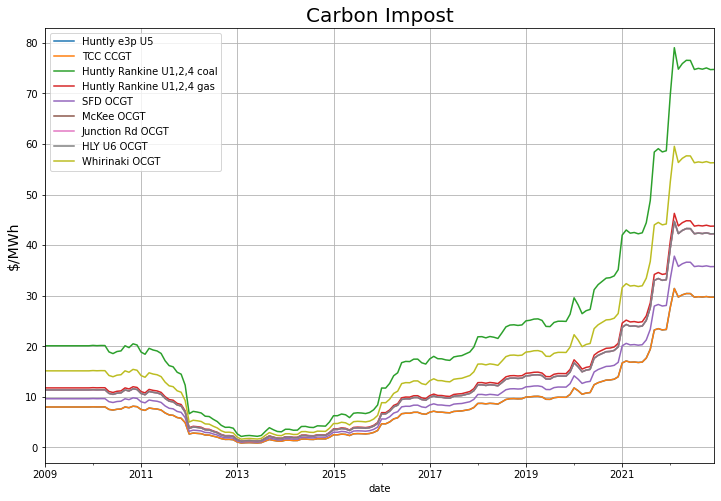

In [0]:
ax=CarbonImpost.plot(figsize=[12,8])
plt.ylabel('$/MWh', fontsize=14)
ax.set_title('Carbon Impost', fontsize=20)
plt.grid()

In [0]:
#Use Rankines on coal (worst case approx)
CarbonImpost=pd.DataFrame(CarbonImpost.max(axis=1))

#or use CCGT to get a (sort of) lower bound
# CarbonImpost=pd.DataFrame(CarbonImpost.min(axis=1))

CarbonImpost.index.set_names('tradingDateTime', inplace=True)
CarbonImpost.head()

0 
 
 
 tradingDateTime 
 
 
 
 
 
 2009-01-01 
 20.09524 
 
 
 2009-02-01 
 20.09524 
 
 
 2009-03-01 
 20.09524 
 
 
 2009-04-01 
 20.09524 
 
 
 2009-05-01 
 20.09524

### No carbon impact when no thermal generation

#### Get total thermal plant generation (ignore geothermals for now)

In [0]:
def getthermaldata():
    ThermalGen = spark.sql("""
    SELECT
      case
        when DaylightSavingIndicator=='NZST' 
          then CONCAT(TradingDate,' ',TradingPeriodStartTime,' +1200')
        when DaylightSavingIndicator=='NZDT' 
          then CONCAT(TradingDate,' ',TradingPeriodStartTime,' +1300')
      end as tradingDateTime,
      cast(sum(SPDGenerationMegawatts) as float) as ThermalGen
    FROM gold.spdnodal
    where 
        CONCAT(PointOfConnectionCode,' ',UnitCode) in ('HLY2201 HLY1','HLY2201 HLY2','HLY2201 HLY3','HLY2201 HLY4','HLY2201 HLY5','HLY2201 HLY6',
        'JRD1101 JRD0','MKE1101 MKE1','NPL2201 NPL3','SFD2201 SFD21', 'SFD2201 SFD22','SFD2201 SPL0','OTA1101 OTG0','OTA2202 OTC0','SWN2201 SWN0',
        'SWN2201 SWN1','SWN2201 SWN5','WHI2201 WHI0')
        and CaseTypeCode = 'FP'
    group by tradingDateTime
     """).toPandas()
# 
    ThermalGen.tradingDateTime=pd.to_datetime(ThermalGen.tradingDateTime, utc=True).dt.tz_convert(None) #create timezone naive UTC time
    ThermalGen.set_index(['tradingDateTime'],inplace=True)
    ThermalGen.sort_index(inplace=True)
    return ThermalGen

In [0]:
ThermalGen=getthermaldata()
ThermalGen.head(10)

ThermalGen 
 
 
 tradingDateTime 
 
 
 
 
 
 2009-07-20 23:30:00 
 1871.0 
 
 
 2009-07-21 00:00:00 
 1842.0 
 
 
 2009-07-21 00:30:00 
 1825.0 
 
 
 2009-07-21 01:00:00 
 1824.0 
 
 
 2009-07-21 01:30:00 
 1824.0 
 
 
 2009-07-21 02:00:00 
 1825.0 
 
 
 2009-07-21 02:30:00 
 1827.0 
 
 
 2009-07-21 03:00:00 
 1846.0 
 
 
 2009-07-21 03:30:00 
 1874.0 
 
 
 2009-07-21 04:00:00 
 1903.0

In [0]:
ThermalGen.tail()

ThermalGen 
 
 
 tradingDateTime 
 
 
 
 
 
 2022-10-31 08:30:00 
 262.000000 
 
 
 2022-10-31 09:00:00 
 196.850998 
 
 
 2022-10-31 09:30:00 
 137.567001 
 
 
 2022-10-31 10:00:00 
 135.000000 
 
 
 2022-10-31 10:30:00 
 135.000000

In [0]:
#cut at 6/6/22 to keep the same dates as what Roger had
ThermalGen = ThermalGen[:'2022/6/30']
ThermalGen.tail(10)

ThermalGen 
 
 
 tradingDateTime 
 
 
 
 
 
 2022-06-06 04:00:00 
 641.758972 
 
 
 2022-06-06 04:30:00 
 677.857971 
 
 
 2022-06-06 05:00:00 
 819.572998 
 
 
 2022-06-06 05:30:00 
 886.299988 
 
 
 2022-06-06 06:00:00 
 884.299988 
 
 
 2022-06-06 06:30:00 
 885.799988 
 
 
 2022-06-06 07:00:00 
 887.299988 
 
 
 2022-06-06 07:30:00 
 865.591003 
 
 
 2022-06-06 08:00:00 
 830.135010 
 
 
 2022-06-06 08:30:00 
 741.299988 
 
 
 2022-06-06 09:00:00 
 645.200012 
 
 
 2022-06-06 09:30:00 
 599.200012 
 
 
 2022-06-06 10:00:00 
 550.000000 
 
 
 2022-06-06 10:30:00 
 400.000000 
 
 
 2022-06-06 11:00:00 
 365.000000 
 
 
 2022-06-06 11:30:00 
 365.000000 
 
 
 2022-06-06 12:00:00 
 454.665009 
 
 
 2022-06-06 12:30:00 
 415.000000 
 
 
 2022-06-06 13:00:00 
 515.000000 
 
 
 2022-06-06 13:30:00 
 515.000000 
 
 
 2022-06-06 14:00:00 
 515.000000 
 
 
 2022-06-06 14:30:00 
 500.976013 
 
 
 2022-06-06 15:00:00 
 475.000000 
 
 
 2022-06-06 15:30:00 
 484.566010 
 
 
 2022-06-06 16:00:00 
 495.000000 
 
 
 2022-06-06 16:30:00 
 497.475006 
 
 
 2022-06-06 17:00:00 
 557.968994 
 
 
 2022-06-06 17:30:00 
 480.000000 
 
 
 2022-06-06 18:00:00 
 547.099976 
 
 
 2022-06-06 18:30:00 
 643.599976 
 
 
 2022-06-06 19:00:00 
 779.799988 
 
 
 2022-06-06 19:30:00 
 963.734009 
 
 
 2022-06-06 20:00:00 
 968.515015 
 
 
 2022-06-06 20:30:00 
 910.560974 
 
 
 2022-06-06 21:00:00 
 866.656006 
 
 
 2022-06-06 21:30:00 
 840.200012 
 
 
 2022-06-06 22:00:00 
 783.799988 
 
 
 2022-06-06 22:30:00 
 739.299988 
 
 
 2022-06-06 23:00:00 
 738.271973 
 
 
 2022-06-06 23:30:00 
 772.625977

In [0]:
ThermalGen.shape

Out[29]: (225793, 1)

Out[30]: <AxesSubplot:>

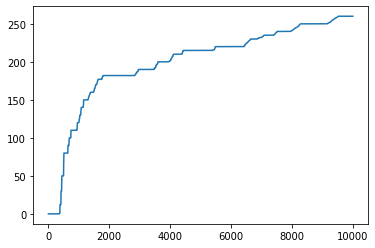

In [0]:
ThermalGen.ThermalGen.sort_values().reset_index(drop=True).head(10000).plot()

In [0]:
# percent of trading periods with no thermal gen
ThermalGen[ThermalGen.ThermalGen==0.].count()/ThermalGen.shape[0]*100

Out[31]: ThermalGen    0.15058
dtype: float64

In [0]:
# Only 0.2% of trading periods have no thermal, 
# however most of them are concentrated in late 2021 (where carbon price is high), 
# so only count trading periods with thermal generation.

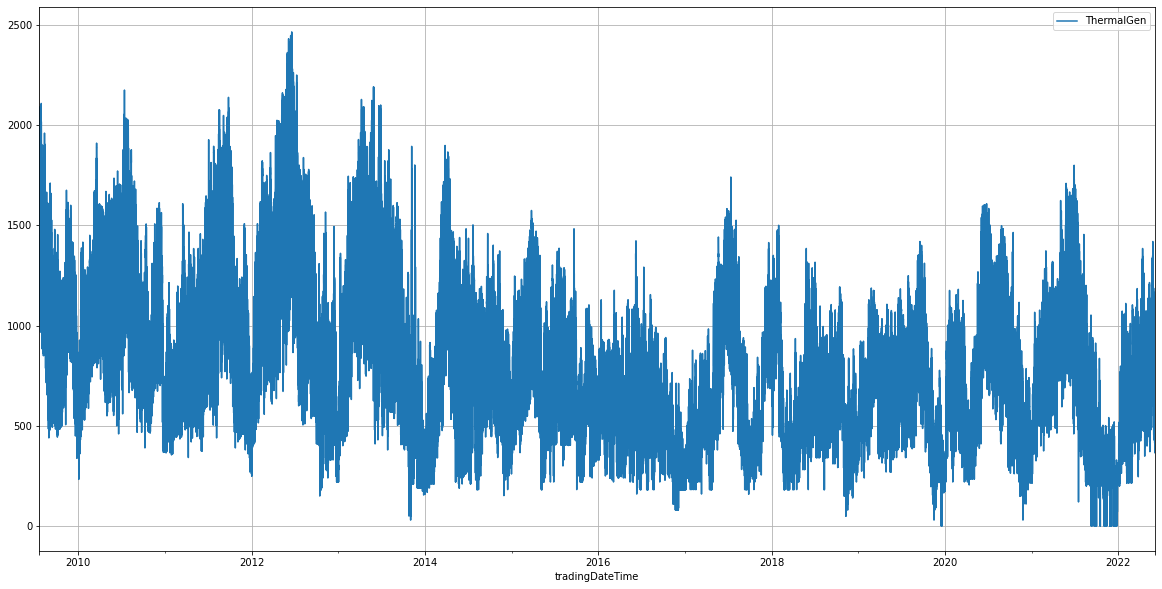

In [0]:
ThermalGen.plot(figsize=[20,10])
plt.grid()

Out[34]: <AxesSubplot:xlabel='tradingDateTime'>

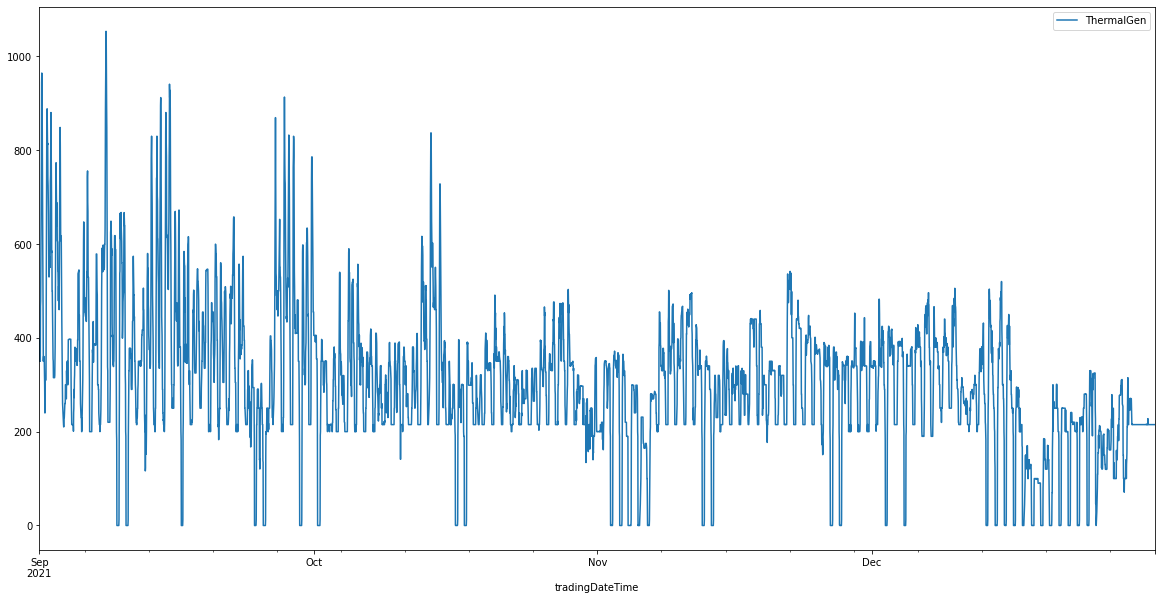

In [0]:
ThermalGen['2021-09-01':'2021-12-31'].plot(figsize=[20,10])#,marker='.')

In [0]:
temp=ThermalGen.join(CarbonImpost, how='outer')
temp[0]=temp[0].fillna(method='ffill')

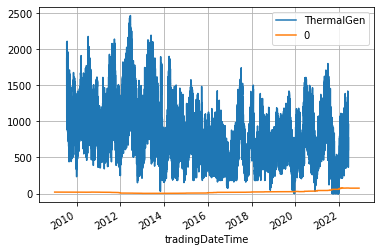

In [0]:
temp.plot()
plt.grid()

In [0]:
CarbonImpost=ThermalGen.join(CarbonImpost, how='outer')
CarbonImpost[0]=CarbonImpost[0].fillna(method='ffill')

In [0]:
CarbonImpost=CarbonImpost[CarbonImpost.ThermalGen.notna()]
CarbonImpost.head()

ThermalGen 
 0 
 
 
 tradingDateTime 
 
 
 
 
 
 
 2009-07-20 23:30:00 
 1871.0 
 20.09524 
 
 
 2009-07-21 00:00:00 
 1842.0 
 20.09524 
 
 
 2009-07-21 00:30:00 
 1825.0 
 20.09524 
 
 
 2009-07-21 01:00:00 
 1824.0 
 20.09524 
 
 
 2009-07-21 01:30:00 
 1824.0 
 20.09524

Out[39]: <AxesSubplot:xlabel='tradingDateTime'>

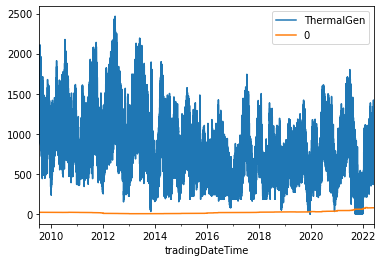

In [0]:
CarbonImpost.plot()

In [0]:
# Set impost to zero when no thermal gen
CarbonImpost.loc[CarbonImpost.ThermalGen==0.,0]=0

Out[41]: <AxesSubplot:xlabel='tradingDateTime'>

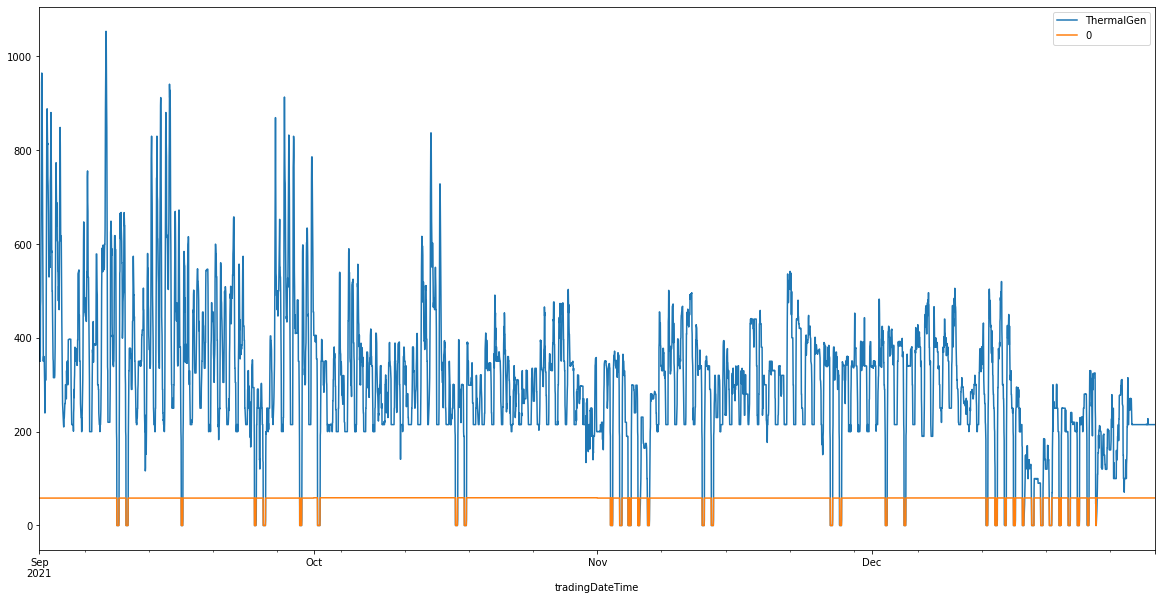

In [0]:
CarbonImpost['2021-09-01':'2021-12-31'].plot(figsize=[20,10])

In [0]:
CarbonImpost=CarbonImpost[0]

Out[43]: <AxesSubplot:xlabel='tradingDateTime'>

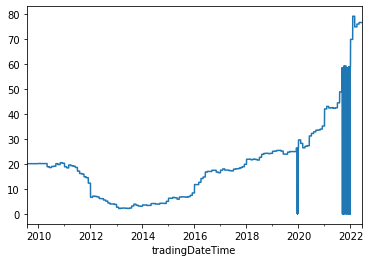

In [0]:
CarbonImpost.plot()

### Get renewable generation by Trader (include geothermals for now)

In [0]:
# Roger's new - joins to offers table to get participant code (to reduce amount of data returned)

def getRenewableGenJoinOffers():
    RenewableGen = spark.sql("""
    SELECT
      case
        when n.DaylightSavingIndicator=='NZST' 
          then CONCAT(n.TradingDate,' ',n.TradingPeriodStartTime,' +1200')
        when n.DaylightSavingIndicator=='NZDT' 
          then CONCAT(n.TradingDate,' ',n.TradingPeriodStartTime,' +1300')
      end as tradingDateTime,
      ParticipantCode as Trader_Id,
      cast(sum(SPDGenerationMegawatts) as float) as RenewableGen
    FROM gold.spdnodal n
        left join gold.offers o on n.PointOfConnectionCode == o.PointOfConnectionCode AND 
                                   n.UnitCode == o.UnitCode AND
                                   n.TradingDate == o.TradingDate AND
                                   n.TradingPeriodNumber == o.TradingPeriodNumber
    where 
        CONCAT(n.PointOfConnectionCode,' ',n.UnitCode) not in ('HLY2201 HLY1','HLY2201 HLY2','HLY2201 HLY3','HLY2201 HLY4','HLY2201 HLY5','HLY2201 HLY6',
        'JRD1101 JRD0','MKE1101 MKE1','NPL2201 NPL3','SFD2201 SFD21','SFD2201 SFD22','SFD2201 SPL0','OTA1101 OTG0','OTA2202 OTC0','SWN2201 SWN0',
        'SWN2201 SWN1','SWN2201 SWN5','WHI2201 WHI0')
        and n.CaseTypeCode = 'FP'
        and IsLatestSubmissionFlag = 'Y'
        and o.ProductType = 'Energy'
        and o.TrancheNumber = 1
    group by tradingDateTime, Trader_Id
    """).toPandas()

    RenewableGen.tradingDateTime=pd.to_datetime(RenewableGen.tradingDateTime, utc=True).dt.tz_convert(None) #create timezone naive UTC time
    RenewableGen.set_index(['tradingDateTime','Trader_Id'],inplace=True)
    RenewableGen.sort_index(inplace=True)
    return RenewableGen
  

In [0]:
RenewableGen=getRenewableGenJoinOffers()

In [0]:
RenewableGen.head()

RenewableGen 
 
 
 tradingDateTime 
 Trader_Id 
 
 
 
 
 
 2012-12-31 11:00:00 
 ALNT 
 60.00000 
 
 
 CTCT 
 719.01001 
 
 
 GENE 
 226.00000 
 
 
 KING 
 28.00000 
 
 
 MERI 
 1178.00000

In [0]:
RenewableGen.groupby(level=1).count()

RenewableGen 
 
 
 Trader_Id 
 
 
 
 
 
 ALNT 
 172368 
 
 
 CNIR 
 18988 
 
 
 CTCT 
 172368 
 
 
 GENE 
 172368 
 
 
 KING 
 172368 
 
 
 MERI 
 172368 
 
 
 MRPL 
 172368 
 
 
 NAPJ 
 172368 
 
 
 NGAG 
 35472 
 
 
 NZWF 
 172368 
 
 
 PUNZ 
 114070 
 
 
 SKOG 
 172368 
 
 
 TAOM 
 81216 
 
 
 TODD 
 172368 
 
 
 TRUS 
 153380 
 
 
 TUAR 
 172368

In [0]:
RenewableGen.head()

RenewableGen 
 
 
 tradingDateTime 
 Trader_Id 
 
 
 
 
 
 2012-12-31 11:00:00 
 ALNT 
 60.00000 
 
 
 CTCT 
 719.01001 
 
 
 GENE 
 226.00000 
 
 
 KING 
 28.00000 
 
 
 MERI 
 1178.00000

In [0]:
RenewableGen.tail()

RenewableGen 
 
 
 tradingDateTime 
 Trader_Id 
 
 
 
 
 
 2022-10-31 10:30:00 
 PUNZ 
 21.200001 
 
 
 SKOG 
 28.000000 
 
 
 TAOM 
 24.000000 
 
 
 TODD 
 14.000000 
 
 
 TUAR 
 88.000000

#### Trim to clean start and end of financial years

In [0]:
RenewableGen = RenewableGen['2013-07-01':'2022-06-30 23:30']
RenewableGen.tail()

RenewableGen 
 
 
 tradingDateTime 
 Trader_Id 
 
 
 
 
 
 2022-06-30 23:30:00 
 PUNZ 
 16.82 
 
 
 SKOG 
 46.00 
 
 
 TAOM 
 24.00 
 
 
 TODD 
 5.00 
 
 
 TUAR 
 92.00

Out[77]: <AxesSubplot:xlabel='Trader_Id'>

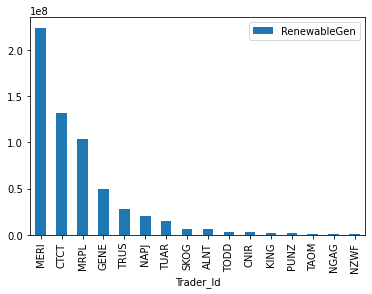

In [0]:
RenewableGen.groupby(level=1).sum().sort_values(by='RenewableGen',ascending=False).plot(kind='bar')

In [0]:
RenewableGen.head(13)

RenewableGen 
 
 
 tradingDateTime 
 Trader_Id 
 
 
 
 
 
 2013-07-01 00:00:00 
 ALNT 
 55.0 
 
 
 CTCT 
 847.0 
 
 
 GENE 
 239.0 
 
 
 KING 
 0.0 
 
 
 MERI 
 1245.0 
 
 
 MRPL 
 713.0 
 
 
 NAPJ 
 139.0 
 
 
 NZWF 
 0.0 
 
 
 SKOG 
 18.0 
 
 
 TODD 
 38.0 
 
 
 TRUS 
 266.0 
 
 
 TUAR 
 14.0 
 
 
 2013-07-01 00:30:00 
 ALNT 
 55.0

In [0]:
RenewableGen.shape

Out[80]: (2106436, 1)

### Calculate carbon windfall

In [0]:
CarbonImpost=RenewableGen.join(CarbonImpost)
CarbonImpost.rename(columns={0:'CarbonImpost'},inplace=True)
CarbonImpost.head(15)

RenewableGen 
 CarbonImpost 
 
 
 tradingDateTime 
 Trader_Id 
 
 
 
 
 
 
 2013-07-01 00:00:00 
 ALNT 
 55.0 
 2.356005 
 
 
 CTCT 
 847.0 
 2.356005 
 
 
 GENE 
 239.0 
 2.356005 
 
 
 KING 
 0.0 
 2.356005 
 
 
 MERI 
 1245.0 
 2.356005 
 
 
 MRPL 
 713.0 
 2.356005 
 
 
 NAPJ 
 139.0 
 2.356005 
 
 
 NZWF 
 0.0 
 2.356005 
 
 
 SKOG 
 18.0 
 2.356005 
 
 
 TODD 
 38.0 
 2.356005 
 
 
 TRUS 
 266.0 
 2.356005 
 
 
 TUAR 
 14.0 
 2.356005 
 
 
 2013-07-01 00:30:00 
 ALNT 
 55.0 
 2.356005 
 
 
 CTCT 
 847.0 
 2.356005 
 
 
 GENE 
 229.0 
 2.356005

In [0]:
CarbonImpost['Dollars']=CarbonImpost.CarbonImpost*CarbonImpost.RenewableGen/2
CarbonImpost.head()

RenewableGen 
 CarbonImpost 
 Dollars 
 
 
 tradingDateTime 
 Trader_Id 
 
 
 
 
 
 
 
 2013-07-01 
 ALNT 
 55.0 
 2.356005 
 64.790133 
 
 
 CTCT 
 847.0 
 2.356005 
 997.768046 
 
 
 GENE 
 239.0 
 2.356005 
 281.542577 
 
 
 KING 
 0.0 
 2.356005 
 0.000000 
 
 
 MERI 
 1245.0 
 2.356005 
 1466.613008

In [0]:
CarbonImpost=CarbonImpost.Dollars.unstack()
CarbonImpost.head()

Trader_Id 
 ALNT 
 CNIR 
 CTCT 
 GENE 
 KING 
 MERI 
 MRPL 
 NAPJ 
 NGAG 
 NZWF 
 PUNZ 
 SKOG 
 TAOM 
 TODD 
 TRUS 
 TUAR 
 
 
 tradingDateTime 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2013-07-01 00:00:00 
 64.790133 
 NaN 
 997.768046 
 281.542577 
 0.0 
 1466.613008 
 839.915722 
 163.742336 
 NaN 
 0.0 
 NaN 
 21.204043 
 NaN 
 44.764092 
 313.348643 
 16.492034 
 
 
 2013-07-01 00:30:00 
 64.790133 
 NaN 
 997.768046 
 269.762553 
 0.0 
 1431.272935 
 837.559718 
 163.742336 
 NaN 
 0.0 
 NaN 
 21.204043 
 NaN 
 44.764092 
 309.814635 
 16.492034 
 
 
 2013-07-01 01:00:00 
 55.366114 
 NaN 
 997.768046 
 269.762553 
 0.0 
 1448.942971 
 812.939438 
 163.742336 
 NaN 
 0.0 
 NaN 
 21.204043 
 NaN 
 44.764092 
 285.076585 
 16.492034 
 
 
 2013-07-01 01:30:00 
 55.366114 
 NaN 
 997.768046 
 187.302384 
 0.0 
 1358.236785 
 739.785517 
 163.742336 
 NaN 
 0.0 
 NaN 
 21.204043 
 NaN 
 44.764092 
 287.432589 
 16.492034 
 
 
 2013-07-01 02:00:00 
 55.366114 
 NaN 
 997.768046 
 187.302384 
 0.0 
 1314.650696 
 678.529392 
 163.742336 
 NaN 
 0.0 
 NaN 
 21.204043 
 NaN 
 44.764092 
 283.898582 
 16.492034

#### Group into financial years

In [0]:
CarbonImpost6M=CarbonImpost.resample('6MS').sum()
CarbonImpost6M

Trader_Id 
 ALNT 
 CTCT 
 GENE 
 KING 
 MERI 
 MRPL 
 NAPJ 
 NGAG 
 NZWF 
 PUNZ 
 SKOG 
 TAOM 
 TODD 
 TUAR 
 TRUS/CNIR 
 
 
 tradingDateTime 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2013-07-01 
 6.777140e+05 
 1.116038e+07 
 4.716016e+06 
 2.479058e+05 
 1.912741e+07 
 8.711802e+06 
 1.611418e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 3.262907e+05 
 0.000000e+00 
 4.850608e+05 
 1.353459e+06 
 2.722120e+06 
 
 
 2014-01-01 
 7.492012e+05 
 1.280856e+07 
 3.991611e+06 
 2.507045e+05 
 2.209369e+07 
 9.354573e+06 
 2.018860e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 7.749235e+05 
 0.000000e+00 
 4.879468e+05 
 1.722575e+06 
 2.913333e+06 
 
 
 2014-07-01 
 9.417969e+05 
 1.639940e+07 
 5.762265e+06 
 3.260974e+05 
 2.640036e+07 
 1.122237e+07 
 2.286065e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 9.306881e+05 
 0.000000e+00 
 6.529736e+05 
 1.929471e+06 
 3.963787e+06 
 
 
 2015-01-01 
 1.412839e+06 
 2.333670e+07 
 8.156201e+06 
 3.418644e+05 
 3.672622e+07 
 1.581672e+07 
 3.646250e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 1.328558e+06 
 0.000000e+00 
 8.339622e+05 
 2.732150e+06 
 4.565062e+06 
 
 
 2015-07-01 
 1.514450e+06 
 2.737098e+07 
 1.011792e+07 
 6.516977e+05 
 4.389409e+07 
 2.226756e+07 
 3.897463e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 1.314409e+06 
 0.000000e+00 
 1.205984e+06 
 3.269374e+06 
 6.052278e+06 
 
 
 2016-01-01 
 2.782703e+06 
 5.360930e+07 
 1.691556e+07 
 6.679628e+05 
 8.436659e+07 
 3.443144e+07 
 8.091702e+06 
 0.000000e+00 
 0.000000e+00 
 2.515422e+05 
 2.647516e+06 
 0.000000e+00 
 1.440253e+06 
 6.150923e+06 
 8.310283e+06 
 
 
 2016-07-01 
 3.571980e+06 
 6.430297e+07 
 2.735269e+07 
 1.616970e+06 
 1.073127e+08 
 5.522519e+07 
 1.009425e+07 
 0.000000e+00 
 0.000000e+00 
 1.338804e+06 
 3.601292e+06 
 0.000000e+00 
 1.373874e+06 
 7.452652e+06 
 1.534409e+07 
 
 
 2017-01-01 
 3.894157e+06 
 5.813772e+07 
 2.653581e+07 
 1.374892e+06 
 9.973556e+07 
 5.663852e+07 
 1.019399e+07 
 0.000000e+00 
 0.000000e+00 
 1.095900e+06 
 3.427622e+06 
 0.000000e+00 
 1.520897e+06 
 7.396040e+06 
 1.444732e+07 
 
 
 2017-07-01 
 4.011072e+06 
 6.533431e+07 
 3.113705e+07 
 1.251689e+06 
 9.872031e+07 
 6.674453e+07 
 1.010726e+07 
 0.000000e+00 
 0.000000e+00 
 1.734413e+06 
 3.972989e+06 
 0.000000e+00 
 2.211789e+06 
 6.822216e+06 
 1.837025e+07 
 
 
 2018-01-01 
 4.436160e+06 
 7.742968e+07 
 2.955093e+07 
 1.558491e+06 
 1.301291e+08 
 6.704464e+07 
 1.306647e+07 
 0.000000e+00 
 0.000000e+00 
 1.640946e+06 
 3.873035e+06 
 1.096396e+01 
 1.777498e+06 
 8.113269e+06 
 1.729726e+07 
 
 
 2018-07-01 
 5.042355e+06 
 9.276766e+07 
 4.040953e+07 
 1.794955e+06 
 1.417987e+08 
 8.082066e+07 
 1.416816e+07 
 0.000000e+00 
 0.000000e+00 
 2.078771e+06 
 4.898255e+06 
 9.961077e+05 
 2.130636e+06 
 8.814543e+06 
 2.096508e+07 
 
 
 2019-01-01 
 5.711375e+06 
 9.731505e+07 
 2.754210e+07 
 1.371365e+06 
 1.604458e+08 
 6.192523e+07 
 1.494790e+07 
 0.000000e+00 
 0.000000e+00 
 1.379135e+06 
 4.596158e+06 
 2.398414e+06 
 2.952093e+06 
 9.885745e+06 
 1.476086e+07 
 
 
 2019-07-01 
 5.315032e+06 
 9.169963e+07 
 3.601216e+07 
 1.842287e+06 
 1.716921e+08 
 7.526357e+07 
 1.345178e+07 
 0.000000e+00 
 1.017480e+06 
 1.968253e+06 
 4.868939e+06 
 2.437803e+06 
 2.074587e+06 
 9.561300e+06 
 2.592202e+07 
 
 
 2020-01-01 
 5.065277e+06 
 1.028267e+08 
 2.490151e+07 
 1.395870e+06 
 1.986807e+08 
 6.972258e+07 
 1.712289e+07 
 0.000000e+00 
 1.431100e+06 
 1.313800e+06 
 4.710893e+06 
 2.886328e+06 
 1.555484e+06 
 1.158097e+07 
 2.504403e+07 
 
 
 2020-07-01 
 5.577689e+06 
 1.229250e+08 
 4.975311e+07 
 2.614413e+06 
 2.236624e+08 
 9.768018e+07 
 1.987226e+07 
 2.642821e+03 
 2.178148e+06 
 2.190103e+06 
 6.676133e+06 
 3.623878e+06 
 2.180507e+06 
 1.264905e+07 
 3.671500e+07 
 
 
 2021-01-01 
 0.000000e+00 
 1.454085e+08 
 5.284114e+07 
 2.114849e+06 
 2.545917e+08 
 1.042537e+08 
 2.550518e+07 
 4.769745e+06 
 1.930850e+06 
 1.601862e+06 
 8.244141e+06 
 4.243233e+

In [0]:
CarbonImpost6M.reset_index(inplace=True)
CarbonImpost6M

Trader_Id 
 tradingDateTime 
 ALNT 
 CTCT 
 GENE 
 KING 
 MERI 
 MRPL 
 NAPJ 
 NGAG 
 NZWF 
 PUNZ 
 SKOG 
 TAOM 
 TODD 
 TUAR 
 TRUS/CNIR 
 
 
 
 
 0 
 2013-07-01 
 6.777140e+05 
 1.116038e+07 
 4.716016e+06 
 2.479058e+05 
 1.912741e+07 
 8.711802e+06 
 1.611418e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 3.262907e+05 
 0.000000e+00 
 4.850608e+05 
 1.353459e+06 
 2.722120e+06 
 
 
 1 
 2014-01-01 
 7.492012e+05 
 1.280856e+07 
 3.991611e+06 
 2.507045e+05 
 2.209369e+07 
 9.354573e+06 
 2.018860e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 7.749235e+05 
 0.000000e+00 
 4.879468e+05 
 1.722575e+06 
 2.913333e+06 
 
 
 2 
 2014-07-01 
 9.417969e+05 
 1.639940e+07 
 5.762265e+06 
 3.260974e+05 
 2.640036e+07 
 1.122237e+07 
 2.286065e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 9.306881e+05 
 0.000000e+00 
 6.529736e+05 
 1.929471e+06 
 3.963787e+06 
 
 
 3 
 2015-01-01 
 1.412839e+06 
 2.333670e+07 
 8.156201e+06 
 3.418644e+05 
 3.672622e+07 
 1.581672e+07 
 3.646250e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 1.328558e+06 
 0.000000e+00 
 8.339622e+05 
 2.732150e+06 
 4.565062e+06 
 
 
 4 
 2015-07-01 
 1.514450e+06 
 2.737098e+07 
 1.011792e+07 
 6.516977e+05 
 4.389409e+07 
 2.226756e+07 
 3.897463e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 1.314409e+06 
 0.000000e+00 
 1.205984e+06 
 3.269374e+06 
 6.052278e+06 
 
 
 5 
 2016-01-01 
 2.782703e+06 
 5.360930e+07 
 1.691556e+07 
 6.679628e+05 
 8.436659e+07 
 3.443144e+07 
 8.091702e+06 
 0.000000e+00 
 0.000000e+00 
 2.515422e+05 
 2.647516e+06 
 0.000000e+00 
 1.440253e+06 
 6.150923e+06 
 8.310283e+06 
 
 
 6 
 2016-07-01 
 3.571980e+06 
 6.430297e+07 
 2.735269e+07 
 1.616970e+06 
 1.073127e+08 
 5.522519e+07 
 1.009425e+07 
 0.000000e+00 
 0.000000e+00 
 1.338804e+06 
 3.601292e+06 
 0.000000e+00 
 1.373874e+06 
 7.452652e+06 
 1.534409e+07 
 
 
 7 
 2017-01-01 
 3.894157e+06 
 5.813772e+07 
 2.653581e+07 
 1.374892e+06 
 9.973556e+07 
 5.663852e+07 
 1.019399e+07 
 0.000000e+00 
 0.000000e+00 
 1.095900e+06 
 3.427622e+06 
 0.000000e+00 
 1.520897e+06 
 7.396040e+06 
 1.444732e+07 
 
 
 8 
 2017-07-01 
 4.011072e+06 
 6.533431e+07 
 3.113705e+07 
 1.251689e+06 
 9.872031e+07 
 6.674453e+07 
 1.010726e+07 
 0.000000e+00 
 0.000000e+00 
 1.734413e+06 
 3.972989e+06 
 0.000000e+00 
 2.211789e+06 
 6.822216e+06 
 1.837025e+07 
 
 
 9 
 2018-01-01 
 4.436160e+06 
 7.742968e+07 
 2.955093e+07 
 1.558491e+06 
 1.301291e+08 
 6.704464e+07 
 1.306647e+07 
 0.000000e+00 
 0.000000e+00 
 1.640946e+06 
 3.873035e+06 
 1.096396e+01 
 1.777498e+06 
 8.113269e+06 
 1.729726e+07 
 
 
 10 
 2018-07-01 
 5.042355e+06 
 9.276766e+07 
 4.040953e+07 
 1.794955e+06 
 1.417987e+08 
 8.082066e+07 
 1.416816e+07 
 0.000000e+00 
 0.000000e+00 
 2.078771e+06 
 4.898255e+06 
 9.961077e+05 
 2.130636e+06 
 8.814543e+06 
 2.096508e+07 
 
 
 11 
 2019-01-01 
 5.711375e+06 
 9.731505e+07 
 2.754210e+07 
 1.371365e+06 
 1.604458e+08 
 6.192523e+07 
 1.494790e+07 
 0.000000e+00 
 0.000000e+00 
 1.379135e+06 
 4.596158e+06 
 2.398414e+06 
 2.952093e+06 
 9.885745e+06 
 1.476086e+07 
 
 
 12 
 2019-07-01 
 5.315032e+06 
 9.169963e+07 
 3.601216e+07 
 1.842287e+06 
 1.716921e+08 
 7.526357e+07 
 1.345178e+07 
 0.000000e+00 
 1.017480e+06 
 1.968253e+06 
 4.868939e+06 
 2.437803e+06 
 2.074587e+06 
 9.561300e+06 
 2.592202e+07 
 
 
 13 
 2020-01-01 
 5.065277e+06 
 1.028267e+08 
 2.490151e+07 
 1.395870e+06 
 1.986807e+08 
 6.972258e+07 
 1.712289e+07 
 0.000000e+00 
 1.431100e+06 
 1.313800e+06 
 4.710893e+06 
 2.886328e+06 
 1.555484e+06 
 1.158097e+07 
 2.504403e+07 
 
 
 14 
 2020-07-01 
 5.577689e+06 
 1.229250e+08 
 4.975311e+07 
 2.614413e+06 
 2.236624e+08 
 9.768018e+07 
 1.987226e+07 
 2.642821e+03 
 2.178148e+06 
 2.190103e+06 
 6.676133e+06 
 3.623878e+06 
 2.180507e+06 
 1.264905e+07 
 3.671500e+07 
 
 
 15 
 2021-01-01 
 0.000000e+00 
 1.454085e+08 
 5.284114e+07 
 2.114849e+06 
 2.545917e+08 
 1.042537e+08 
 2.550518e+07 
 4.769745e+06 
 1.930850e+06 
 1.60

In [0]:
finYrStrt=CarbonImpost6M.loc[CarbonImpost6M.index.map(lambda x: x%2==0)][['tradingDateTime']].reset_index(drop=True)
finYrStrt

Trader_Id 
 tradingDateTime 
 
 
 
 
 0 
 2013-07-01 
 
 
 1 
 2014-07-01 
 
 
 2 
 2015-07-01 
 
 
 3 
 2016-07-01 
 
 
 4 
 2017-07-01 
 
 
 5 
 2018-07-01 
 
 
 6 
 2019-07-01 
 
 
 7 
 2020-07-01 
 
 
 8 
 2021-07-01

In [0]:
# CarbonImpost6M['group']=[0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12]
CarbonImpost6M['group']=[0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8]
CarbonImpost6M

Trader_Id 
 tradingDateTime 
 ALNT 
 CTCT 
 GENE 
 KING 
 MERI 
 MRPL 
 NAPJ 
 NGAG 
 NZWF 
 PUNZ 
 SKOG 
 TAOM 
 TODD 
 TUAR 
 TRUS/CNIR 
 group 
 
 
 
 
 0 
 2013-07-01 
 6.777140e+05 
 1.116038e+07 
 4.716016e+06 
 2.479058e+05 
 1.912741e+07 
 8.711802e+06 
 1.611418e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 3.262907e+05 
 0.000000e+00 
 4.850608e+05 
 1.353459e+06 
 2.722120e+06 
 0 
 
 
 1 
 2014-01-01 
 7.492012e+05 
 1.280856e+07 
 3.991611e+06 
 2.507045e+05 
 2.209369e+07 
 9.354573e+06 
 2.018860e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 7.749235e+05 
 0.000000e+00 
 4.879468e+05 
 1.722575e+06 
 2.913333e+06 
 0 
 
 
 2 
 2014-07-01 
 9.417969e+05 
 1.639940e+07 
 5.762265e+06 
 3.260974e+05 
 2.640036e+07 
 1.122237e+07 
 2.286065e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 9.306881e+05 
 0.000000e+00 
 6.529736e+05 
 1.929471e+06 
 3.963787e+06 
 1 
 
 
 3 
 2015-01-01 
 1.412839e+06 
 2.333670e+07 
 8.156201e+06 
 3.418644e+05 
 3.672622e+07 
 1.581672e+07 
 3.646250e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 1.328558e+06 
 0.000000e+00 
 8.339622e+05 
 2.732150e+06 
 4.565062e+06 
 1 
 
 
 4 
 2015-07-01 
 1.514450e+06 
 2.737098e+07 
 1.011792e+07 
 6.516977e+05 
 4.389409e+07 
 2.226756e+07 
 3.897463e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 1.314409e+06 
 0.000000e+00 
 1.205984e+06 
 3.269374e+06 
 6.052278e+06 
 2 
 
 
 5 
 2016-01-01 
 2.782703e+06 
 5.360930e+07 
 1.691556e+07 
 6.679628e+05 
 8.436659e+07 
 3.443144e+07 
 8.091702e+06 
 0.000000e+00 
 0.000000e+00 
 2.515422e+05 
 2.647516e+06 
 0.000000e+00 
 1.440253e+06 
 6.150923e+06 
 8.310283e+06 
 2 
 
 
 6 
 2016-07-01 
 3.571980e+06 
 6.430297e+07 
 2.735269e+07 
 1.616970e+06 
 1.073127e+08 
 5.522519e+07 
 1.009425e+07 
 0.000000e+00 
 0.000000e+00 
 1.338804e+06 
 3.601292e+06 
 0.000000e+00 
 1.373874e+06 
 7.452652e+06 
 1.534409e+07 
 3 
 
 
 7 
 2017-01-01 
 3.894157e+06 
 5.813772e+07 
 2.653581e+07 
 1.374892e+06 
 9.973556e+07 
 5.663852e+07 
 1.019399e+07 
 0.000000e+00 
 0.000000e+00 
 1.095900e+06 
 3.427622e+06 
 0.000000e+00 
 1.520897e+06 
 7.396040e+06 
 1.444732e+07 
 3 
 
 
 8 
 2017-07-01 
 4.011072e+06 
 6.533431e+07 
 3.113705e+07 
 1.251689e+06 
 9.872031e+07 
 6.674453e+07 
 1.010726e+07 
 0.000000e+00 
 0.000000e+00 
 1.734413e+06 
 3.972989e+06 
 0.000000e+00 
 2.211789e+06 
 6.822216e+06 
 1.837025e+07 
 4 
 
 
 9 
 2018-01-01 
 4.436160e+06 
 7.742968e+07 
 2.955093e+07 
 1.558491e+06 
 1.301291e+08 
 6.704464e+07 
 1.306647e+07 
 0.000000e+00 
 0.000000e+00 
 1.640946e+06 
 3.873035e+06 
 1.096396e+01 
 1.777498e+06 
 8.113269e+06 
 1.729726e+07 
 4 
 
 
 10 
 2018-07-01 
 5.042355e+06 
 9.276766e+07 
 4.040953e+07 
 1.794955e+06 
 1.417987e+08 
 8.082066e+07 
 1.416816e+07 
 0.000000e+00 
 0.000000e+00 
 2.078771e+06 
 4.898255e+06 
 9.961077e+05 
 2.130636e+06 
 8.814543e+06 
 2.096508e+07 
 5 
 
 
 11 
 2019-01-01 
 5.711375e+06 
 9.731505e+07 
 2.754210e+07 
 1.371365e+06 
 1.604458e+08 
 6.192523e+07 
 1.494790e+07 
 0.000000e+00 
 0.000000e+00 
 1.379135e+06 
 4.596158e+06 
 2.398414e+06 
 2.952093e+06 
 9.885745e+06 
 1.476086e+07 
 5 
 
 
 12 
 2019-07-01 
 5.315032e+06 
 9.169963e+07 
 3.601216e+07 
 1.842287e+06 
 1.716921e+08 
 7.526357e+07 
 1.345178e+07 
 0.000000e+00 
 1.017480e+06 
 1.968253e+06 
 4.868939e+06 
 2.437803e+06 
 2.074587e+06 
 9.561300e+06 
 2.592202e+07 
 6 
 
 
 13 
 2020-01-01 
 5.065277e+06 
 1.028267e+08 
 2.490151e+07 
 1.395870e+06 
 1.986807e+08 
 6.972258e+07 
 1.712289e+07 
 0.000000e+00 
 1.431100e+06 
 1.313800e+06 
 4.710893e+06 
 2.886328e+06 
 1.555484e+06 
 1.158097e+07 
 2.504403e+07 
 6 
 
 
 14 
 2020-07-01 
 5.577689e+06 
 1.229250e+08 
 4.975311e+07 
 2.614413e+06 
 2.236624e+08 
 9.768018e+07 
 1.987226e+07 
 2.642821e+03 
 2.178148e+06 
 2.190103e+06 
 6.676133e+06 
 3.623878e+06 
 2.180507e+06 
 1.264905e+07 
 3.671500e+07 
 7 
 
 
 15 
 2021-01-01 
 0.000000e+00 
 1.454085e+08 
 5.284114e+07 
 2.114849e+06 
 2.545917e+0

In [0]:
CarbonImpost6M=CarbonImpost6M.groupby('group').sum()
CarbonImpost6M

Trader_Id 
 ALNT 
 CTCT 
 GENE 
 KING 
 MERI 
 MRPL 
 NAPJ 
 NGAG 
 NZWF 
 PUNZ 
 SKOG 
 TAOM 
 TODD 
 TUAR 
 TRUS/CNIR 
 
 
 group 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 1.426915e+06 
 2.396894e+07 
 8.707627e+06 
 4.986104e+05 
 4.122110e+07 
 1.806637e+07 
 3.630278e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 1.101214e+06 
 0.000000e+00 
 9.730076e+05 
 3.076034e+06 
 5.635453e+06 
 
 
 1 
 2.354636e+06 
 3.973609e+07 
 1.391847e+07 
 6.679618e+05 
 6.312658e+07 
 2.703909e+07 
 5.932314e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 2.259246e+06 
 0.000000e+00 
 1.486936e+06 
 4.661621e+06 
 8.528849e+06 
 
 
 2 
 4.297153e+06 
 8.098028e+07 
 2.703347e+07 
 1.319660e+06 
 1.282607e+08 
 5.669899e+07 
 1.198916e+07 
 0.000000e+00 
 0.000000e+00 
 2.515422e+05 
 3.961926e+06 
 0.000000e+00 
 2.646237e+06 
 9.420297e+06 
 1.436256e+07 
 
 
 3 
 7.466137e+06 
 1.224407e+08 
 5.388850e+07 
 2.991862e+06 
 2.070483e+08 
 1.118637e+08 
 2.028824e+07 
 0.000000e+00 
 0.000000e+00 
 2.434704e+06 
 7.028914e+06 
 0.000000e+00 
 2.894771e+06 
 1.484869e+07 
 2.979141e+07 
 
 
 4 
 8.447233e+06 
 1.427640e+08 
 6.068798e+07 
 2.810180e+06 
 2.288494e+08 
 1.337892e+08 
 2.317373e+07 
 0.000000e+00 
 0.000000e+00 
 3.375360e+06 
 7.846023e+06 
 1.096396e+01 
 3.989288e+06 
 1.493548e+07 
 3.566751e+07 
 
 
 5 
 1.075373e+07 
 1.900827e+08 
 6.795163e+07 
 3.166321e+06 
 3.022445e+08 
 1.427459e+08 
 2.911606e+07 
 0.000000e+00 
 0.000000e+00 
 3.457906e+06 
 9.494413e+06 
 3.394522e+06 
 5.082729e+06 
 1.870029e+07 
 3.572593e+07 
 
 
 6 
 1.038031e+07 
 1.945264e+08 
 6.091367e+07 
 3.238157e+06 
 3.703728e+08 
 1.449862e+08 
 3.057467e+07 
 0.000000e+00 
 2.448580e+06 
 3.282052e+06 
 9.579832e+06 
 5.324130e+06 
 3.630071e+06 
 2.114227e+07 
 5.096605e+07 
 
 
 7 
 5.577689e+06 
 2.683335e+08 
 1.025942e+08 
 4.729262e+06 
 4.782542e+08 
 2.019339e+08 
 4.537744e+07 
 4.772388e+06 
 4.108999e+06 
 3.791965e+06 
 1.492027e+07 
 7.867110e+06 
 4.472782e+06 
 2.981372e+07 
 7.299273e+07 
 
 
 8 
 0.000000e+00 
 4.314090e+08 
 1.783992e+08 
 6.467166e+06 
 7.921248e+08 
 3.344410e+08 
 6.842292e+07 
 1.590895e+07 
 5.680924e+06 
 6.422009e+06 
 1.975181e+07 
 1.174846e+07 
 6.403663e+06 
 4.491550e+07 
 1.106665e+08

In [0]:
CarbonImpost6M=CarbonImpost6M.join(finYrStrt).set_index('tradingDateTime')
CarbonImpost6M

Trader_Id 
 ALNT 
 CTCT 
 GENE 
 KING 
 MERI 
 MRPL 
 NAPJ 
 NGAG 
 NZWF 
 PUNZ 
 SKOG 
 TAOM 
 TODD 
 TUAR 
 TRUS/CNIR 
 
 
 tradingDateTime 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2013-07-01 
 1.426915e+06 
 2.396894e+07 
 8.707627e+06 
 4.986104e+05 
 4.122110e+07 
 1.806637e+07 
 3.630278e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 1.101214e+06 
 0.000000e+00 
 9.730076e+05 
 3.076034e+06 
 5.635453e+06 
 
 
 2014-07-01 
 2.354636e+06 
 3.973609e+07 
 1.391847e+07 
 6.679618e+05 
 6.312658e+07 
 2.703909e+07 
 5.932314e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 2.259246e+06 
 0.000000e+00 
 1.486936e+06 
 4.661621e+06 
 8.528849e+06 
 
 
 2015-07-01 
 4.297153e+06 
 8.098028e+07 
 2.703347e+07 
 1.319660e+06 
 1.282607e+08 
 5.669899e+07 
 1.198916e+07 
 0.000000e+00 
 0.000000e+00 
 2.515422e+05 
 3.961926e+06 
 0.000000e+00 
 2.646237e+06 
 9.420297e+06 
 1.436256e+07 
 
 
 2016-07-01 
 7.466137e+06 
 1.224407e+08 
 5.388850e+07 
 2.991862e+06 
 2.070483e+08 
 1.118637e+08 
 2.028824e+07 
 0.000000e+00 
 0.000000e+00 
 2.434704e+06 
 7.028914e+06 
 0.000000e+00 
 2.894771e+06 
 1.484869e+07 
 2.979141e+07 
 
 
 2017-07-01 
 8.447233e+06 
 1.427640e+08 
 6.068798e+07 
 2.810180e+06 
 2.288494e+08 
 1.337892e+08 
 2.317373e+07 
 0.000000e+00 
 0.000000e+00 
 3.375360e+06 
 7.846023e+06 
 1.096396e+01 
 3.989288e+06 
 1.493548e+07 
 3.566751e+07 
 
 
 2018-07-01 
 1.075373e+07 
 1.900827e+08 
 6.795163e+07 
 3.166321e+06 
 3.022445e+08 
 1.427459e+08 
 2.911606e+07 
 0.000000e+00 
 0.000000e+00 
 3.457906e+06 
 9.494413e+06 
 3.394522e+06 
 5.082729e+06 
 1.870029e+07 
 3.572593e+07 
 
 
 2019-07-01 
 1.038031e+07 
 1.945264e+08 
 6.091367e+07 
 3.238157e+06 
 3.703728e+08 
 1.449862e+08 
 3.057467e+07 
 0.000000e+00 
 2.448580e+06 
 3.282052e+06 
 9.579832e+06 
 5.324130e+06 
 3.630071e+06 
 2.114227e+07 
 5.096605e+07 
 
 
 2020-07-01 
 5.577689e+06 
 2.683335e+08 
 1.025942e+08 
 4.729262e+06 
 4.782542e+08 
 2.019339e+08 
 4.537744e+07 
 4.772388e+06 
 4.108999e+06 
 3.791965e+06 
 1.492027e+07 
 7.867110e+06 
 4.472782e+06 
 2.981372e+07 
 7.299273e+07 
 
 
 2021-07-01 
 0.000000e+00 
 4.314090e+08 
 1.783992e+08 
 6.467166e+06 
 7.921248e+08 
 3.344410e+08 
 6.842292e+07 
 1.590895e+07 
 5.680924e+06 
 6.422009e+06 
 1.975181e+07 
 1.174846e+07 
 6.403663e+06 
 4.491550e+07 
 1.106665e+08

In [0]:
CarbonImpost6M.rename(index=lambda x: str(x.year)+'-'+str(x.year+1), inplace=True)

In [0]:
CarbonImpost6M

Trader_Id 
 ALNT 
 CTCT 
 GENE 
 KING 
 MERI 
 MRPL 
 NAPJ 
 NGAG 
 NZWF 
 PUNZ 
 SKOG 
 TAOM 
 TODD 
 TUAR 
 TRUS/CNIR 
 
 
 tradingDateTime 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2013-2014 
 1.426915e+06 
 2.396894e+07 
 8.707627e+06 
 4.986104e+05 
 4.122110e+07 
 1.806637e+07 
 3.630278e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 1.101214e+06 
 0.000000e+00 
 9.730076e+05 
 3.076034e+06 
 5.635453e+06 
 
 
 2014-2015 
 2.354636e+06 
 3.973609e+07 
 1.391847e+07 
 6.679618e+05 
 6.312658e+07 
 2.703909e+07 
 5.932314e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 2.259246e+06 
 0.000000e+00 
 1.486936e+06 
 4.661621e+06 
 8.528849e+06 
 
 
 2015-2016 
 4.297153e+06 
 8.098028e+07 
 2.703347e+07 
 1.319660e+06 
 1.282607e+08 
 5.669899e+07 
 1.198916e+07 
 0.000000e+00 
 0.000000e+00 
 2.515422e+05 
 3.961926e+06 
 0.000000e+00 
 2.646237e+06 
 9.420297e+06 
 1.436256e+07 
 
 
 2016-2017 
 7.466137e+06 
 1.224407e+08 
 5.388850e+07 
 2.991862e+06 
 2.070483e+08 
 1.118637e+08 
 2.028824e+07 
 0.000000e+00 
 0.000000e+00 
 2.434704e+06 
 7.028914e+06 
 0.000000e+00 
 2.894771e+06 
 1.484869e+07 
 2.979141e+07 
 
 
 2017-2018 
 8.447233e+06 
 1.427640e+08 
 6.068798e+07 
 2.810180e+06 
 2.288494e+08 
 1.337892e+08 
 2.317373e+07 
 0.000000e+00 
 0.000000e+00 
 3.375360e+06 
 7.846023e+06 
 1.096396e+01 
 3.989288e+06 
 1.493548e+07 
 3.566751e+07 
 
 
 2018-2019 
 1.075373e+07 
 1.900827e+08 
 6.795163e+07 
 3.166321e+06 
 3.022445e+08 
 1.427459e+08 
 2.911606e+07 
 0.000000e+00 
 0.000000e+00 
 3.457906e+06 
 9.494413e+06 
 3.394522e+06 
 5.082729e+06 
 1.870029e+07 
 3.572593e+07 
 
 
 2019-2020 
 1.038031e+07 
 1.945264e+08 
 6.091367e+07 
 3.238157e+06 
 3.703728e+08 
 1.449862e+08 
 3.057467e+07 
 0.000000e+00 
 2.448580e+06 
 3.282052e+06 
 9.579832e+06 
 5.324130e+06 
 3.630071e+06 
 2.114227e+07 
 5.096605e+07 
 
 
 2020-2021 
 5.577689e+06 
 2.683335e+08 
 1.025942e+08 
 4.729262e+06 
 4.782542e+08 
 2.019339e+08 
 4.537744e+07 
 4.772388e+06 
 4.108999e+06 
 3.791965e+06 
 1.492027e+07 
 7.867110e+06 
 4.472782e+06 
 2.981372e+07 
 7.299273e+07 
 
 
 2021-2022 
 0.000000e+00 
 4.314090e+08 
 1.783992e+08 
 6.467166e+06 
 7.921248e+08 
 3.344410e+08 
 6.842292e+07 
 1.590895e+07 
 5.680924e+06 
 6.422009e+06 
 1.975181e+07 
 1.174846e+07 
 6.403663e+06 
 4.491550e+07 
 1.106665e+08

In [0]:
CarbonImpost6M.sum().sort_values()

Out[112]: Trader_Id
NZWF         1.223850e+07
NGAG         2.068134e+07
PUNZ         2.301554e+07
KING         2.588918e+07
TAOM         2.833424e+07
TODD         3.157948e+07
ALNT         5.070380e+07
SKOG         7.594366e+07
TUAR         1.615139e+08
NAPJ         2.385048e+08
TRUS/CNIR    3.643370e+08
GENE         5.740948e+08
MRPL         1.171564e+09
CTCT         1.494242e+09
MERI         2.611502e+09
dtype: float64

In [0]:
CarbonImpost6M.fillna(value=0.,inplace=True)
CarbonImpost6M['Total'] = CarbonImpost6M.sum(axis=1)
CarbonImpost6M['Big4']=CarbonImpost6M[['MERI','GENE','CTCT','MRPL']].sum(axis=1)
CarbonImpost6M['Other']=CarbonImpost6M['Total']-CarbonImpost6M['Big4']

In [0]:
CarbonImpost6M

Trader_Id 
 ALNT 
 CTCT 
 GENE 
 KING 
 MERI 
 MRPL 
 NAPJ 
 NGAG 
 NZWF 
 PUNZ 
 SKOG 
 TAOM 
 TODD 
 TUAR 
 TRUS/CNIR 
 total 
 Big4 
 Other 
 
 
 tradingDateTime 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2013-2014 
 1.426915e+06 
 2.396894e+07 
 8.707627e+06 
 4.986104e+05 
 4.122110e+07 
 1.806637e+07 
 3.630278e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 1.101214e+06 
 0.000000e+00 
 9.730076e+05 
 3.076034e+06 
 5.635453e+06 
 1.083056e+08 
 9.196404e+07 
 1.634151e+07 
 
 
 2014-2015 
 2.354636e+06 
 3.973609e+07 
 1.391847e+07 
 6.679618e+05 
 6.312658e+07 
 2.703909e+07 
 5.932314e+06 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 2.259246e+06 
 0.000000e+00 
 1.486936e+06 
 4.661621e+06 
 8.528849e+06 
 1.697118e+08 
 1.438202e+08 
 2.589156e+07 
 
 
 2015-2016 
 4.297153e+06 
 8.098028e+07 
 2.703347e+07 
 1.319660e+06 
 1.282607e+08 
 5.669899e+07 
 1.198916e+07 
 0.000000e+00 
 0.000000e+00 
 2.515422e+05 
 3.961926e+06 
 0.000000e+00 
 2.646237e+06 
 9.420297e+06 
 1.436256e+07 
 3.412220e+08 
 2.929734e+08 
 4.824854e+07 
 
 
 2016-2017 
 7.466137e+06 
 1.224407e+08 
 5.388850e+07 
 2.991862e+06 
 2.070483e+08 
 1.118637e+08 
 2.028824e+07 
 0.000000e+00 
 0.000000e+00 
 2.434704e+06 
 7.028914e+06 
 0.000000e+00 
 2.894771e+06 
 1.484869e+07 
 2.979141e+07 
 5.829859e+08 
 4.952412e+08 
 8.774473e+07 
 
 
 2017-2018 
 8.447233e+06 
 1.427640e+08 
 6.068798e+07 
 2.810180e+06 
 2.288494e+08 
 1.337892e+08 
 2.317373e+07 
 0.000000e+00 
 0.000000e+00 
 3.375360e+06 
 7.846023e+06 
 1.096396e+01 
 3.989288e+06 
 1.493548e+07 
 3.566751e+07 
 6.663353e+08 
 5.660905e+08 
 1.002448e+08 
 
 
 2018-2019 
 1.075373e+07 
 1.900827e+08 
 6.795163e+07 
 3.166321e+06 
 3.022445e+08 
 1.427459e+08 
 2.911606e+07 
 0.000000e+00 
 0.000000e+00 
 3.457906e+06 
 9.494413e+06 
 3.394522e+06 
 5.082729e+06 
 1.870029e+07 
 3.572593e+07 
 8.219167e+08 
 7.030248e+08 
 1.188919e+08 
 
 
 2019-2020 
 1.038031e+07 
 1.945264e+08 
 6.091367e+07 
 3.238157e+06 
 3.703728e+08 
 1.449862e+08 
 3.057467e+07 
 0.000000e+00 
 2.448580e+06 
 3.282052e+06 
 9.579832e+06 
 5.324130e+06 
 3.630071e+06 
 2.114227e+07 
 5.096605e+07 
 9.113651e+08 
 7.707990e+08 
 1.405661e+08 
 
 
 2020-2021 
 5.577689e+06 
 2.683335e+08 
 1.025942e+08 
 4.729262e+06 
 4.782542e+08 
 2.019339e+08 
 4.537744e+07 
 4.772388e+06 
 4.108999e+06 
 3.791965e+06 
 1.492027e+07 
 7.867110e+06 
 4.472782e+06 
 2.981372e+07 
 7.299273e+07 
 1.249540e+09 
 1.051116e+09 
 1.984244e+08 
 
 
 2021-2022 
 0.000000e+00 
 4.314090e+08 
 1.783992e+08 
 6.467166e+06 
 7.921248e+08 
 3.344410e+08 
 6.842292e+07 
 1.590895e+07 
 5.680924e+06 
 6.422009e+06 
 1.975181e+07 
 1.174846e+07 
 6.403663e+06 
 4.491550e+07 
 1.106665e+08 
 2.032762e+09 
 1.736374e+09 
 2.963879e+08

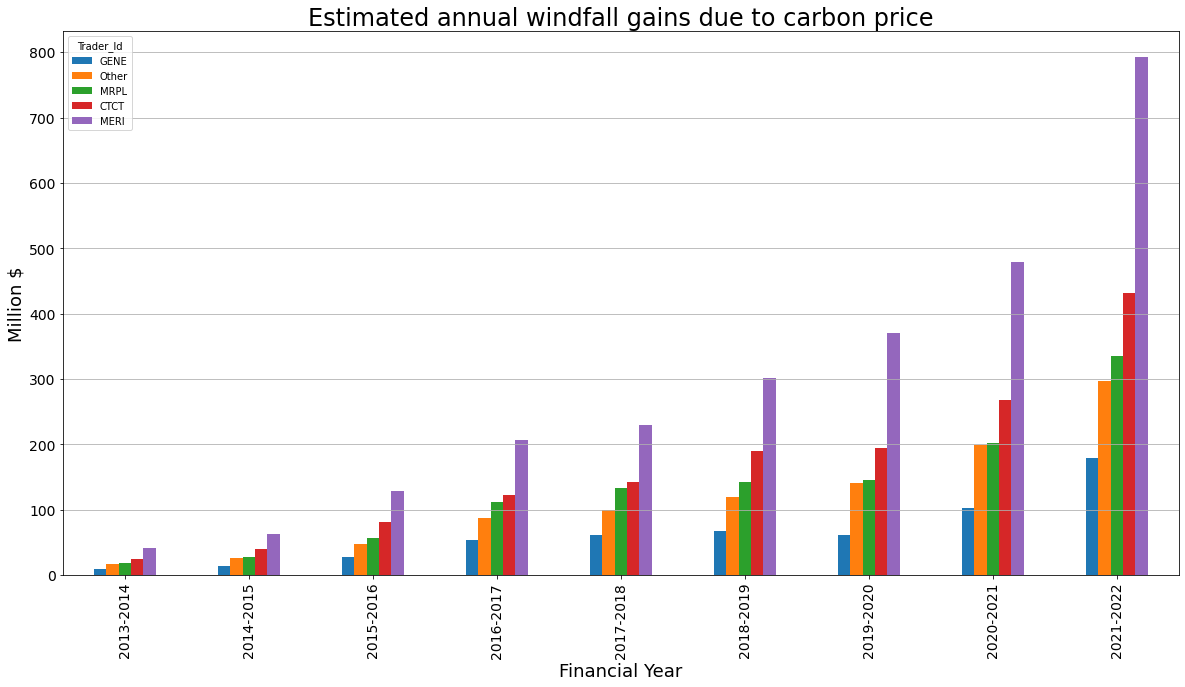

In [0]:
ax=(CarbonImpost6M[['GENE','Other','MRPL','CTCT','MERI']]/1e6).plot(kind='bar',figsize=[20,10])
ax.set_ylabel('Million $',fontsize=18)
ax.set_xlabel('Financial Year',fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax.set_title('Estimated annual windfall gains due to carbon price',fontsize=24)
plt.grid(axis='y')